In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import warnings

sc.set_figure_params(dpi=150)
sc.settings.verbosity = 3
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Data download

In [2]:
import os
# change it according to your preferences
DATA_DIR = "/n/groups/kirschner/xenopus/old_atlas"

NF_stage = "S22"
NF_stage_short = "22"
adata_fp = os.path.join(DATA_DIR, "adata", f"all.{NF_stage}.realigned.corrected.h5ad")
adata_briggs_fp = os.path.join(DATA_DIR, "GSE113074_Raw_combined.annotated_counts.h5ad")

In [3]:
# !gdown 1DhO_z5fLgbGGv9_HbyWbP_P1ILFTyzSm -O $adata_kotov_fp

In [3]:
# !gdown 1iXB73ZNAXF3YNyRWIPVqRs6qdCnzPpUO -O $adata_briggs_fp

In [3]:
adata = sc.read(adata_fp)
adata_briggs = sc.read(adata_briggs_fp)

Only considering the two last: ['.corrected', '.h5ad'].
Only considering the two last: ['.corrected', '.h5ad'].


/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata_briggs.obs["NF_STAGE"] = adata_briggs.obs.Developmental_stage.str.split("_", expand=True).iloc[:,1]

In [5]:
adata_briggs.obs["NF_STAGE"].value_counts()

NF_STAGE
22    37749
20    16642
11    15426
12    13813
16    13478
18    12432
14    10795
13     8931
10     6507
8      1193
Name: count, dtype: int64

In [6]:
adata_briggs = adata_briggs[adata_briggs.obs.NF_STAGE == NF_stage_short]
# adata_briggs = adata_briggs[adata_briggs.obs.Replicate_name == "NPB_dissection"]

In [7]:
adata_briggs.obs["n_genes"] = (adata_briggs.X > 0).sum(axis=1)

/tmp/ipykernel_11893/239584636.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_briggs.obs["n_genes"] = (adata_briggs.X > 0).sum(axis=1)
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
adata_briggs.obs["nUMI_per_cell"] = adata_briggs.X.sum(axis=1)

# Kotov vs Briggs barcode matching

In [9]:
adata_briggs.obs["cell_barcode_v"] = adata_briggs.obs_names.to_series().str.replace("-", "") + adata_briggs.obs.InDrops_version.astype("str")

In [10]:
adata.obs["cell_barcode"] = adata.obs_names.to_series().str.split("-", n=1, expand=True).iloc[:,0]

In [11]:
adata.obs["cell_barcode_v"] = adata.obs.cell_barcode.astype("str") + adata.obs["inDrops_version"].astype("str")

In [12]:
cell_barcodes_vs = np.zeros((len(adata_briggs.obs.Library_name.unique()), len(adata.obs.lib.unique())))

for i, briggs_lib in enumerate(adata_briggs.obs.Library_name.cat.categories):
    adata_i = adata_briggs[adata_briggs.obs.Library_name == briggs_lib]
    for j, new_lib in enumerate(adata.obs.lib.cat.categories):
        adata_j = adata[adata.obs.lib == new_lib]
        cell_barcodes_vs[i, j] = adata_i.obs.cell_barcode_v.isin(adata_j.obs.cell_barcode_v).sum()
        cell_barcodes_vs[i, j] /= adata_i.shape[0]

<Axes: >

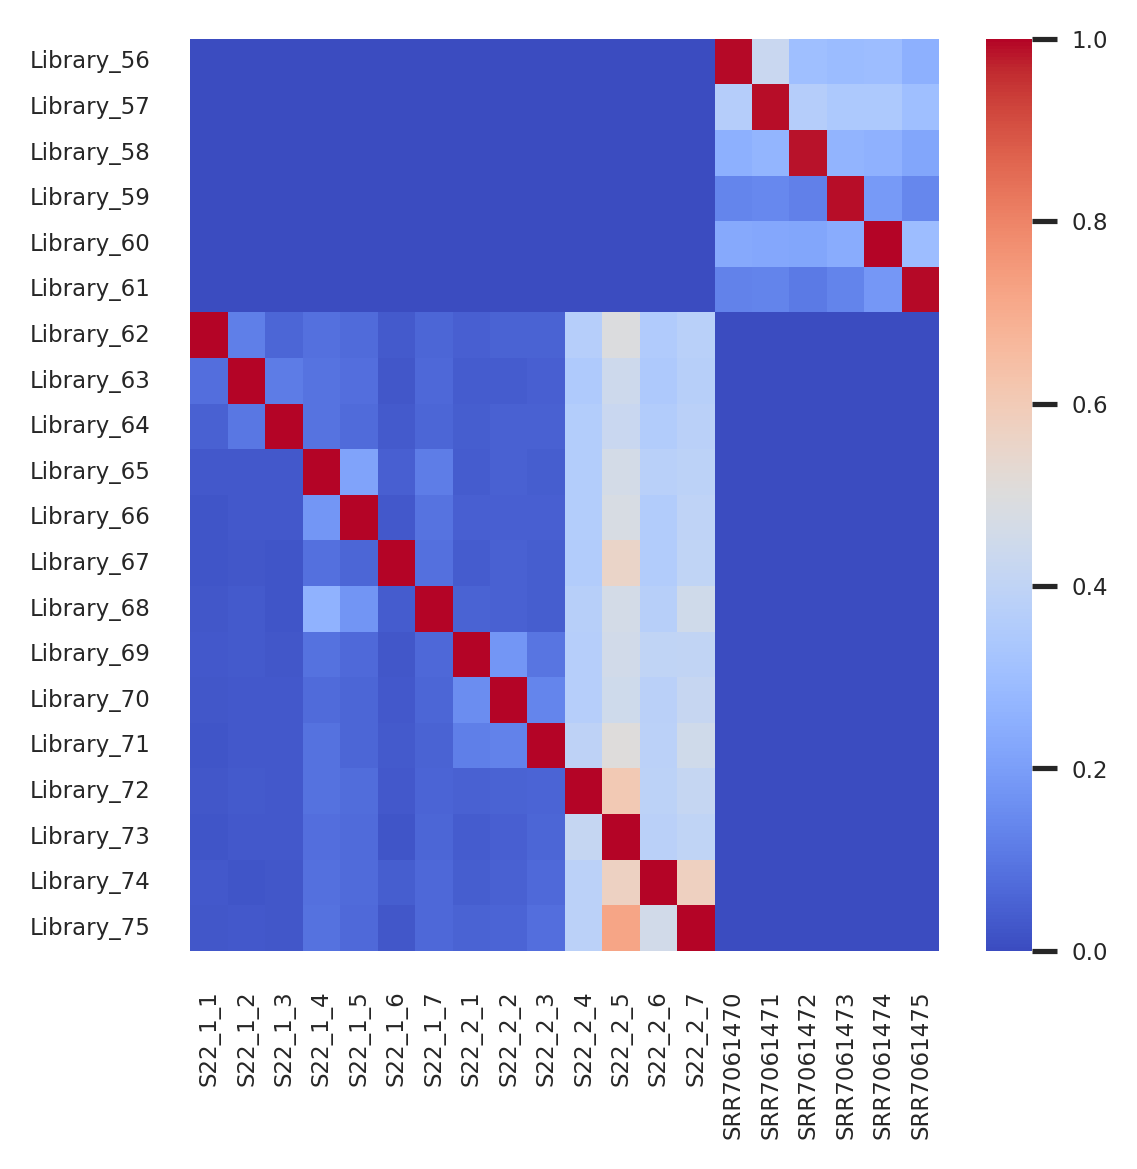

In [13]:
sns.set(font_scale=0.5)
sns.heatmap(
    cell_barcodes_vs,
    cmap="coolwarm",
    xticklabels=adata.obs.lib.cat.categories,
    yticklabels=adata_briggs.obs.Library_name.cat.categories
)

In [14]:
max_briggs = cell_barcodes_vs.argmax(axis=0)
max_briggs

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  0,  1,  2,
        3,  4,  5])

In [15]:
new_to_briggs = {
    cat: adata_briggs.obs.Library_name.cat.categories[max_briggs[i]]
    for i, cat in enumerate(adata.obs.lib.cat.categories)
}

In [16]:
new_to_briggs

{'S22_1_1': 'Library_62',
 'S22_1_2': 'Library_63',
 'S22_1_3': 'Library_64',
 'S22_1_4': 'Library_65',
 'S22_1_5': 'Library_66',
 'S22_1_6': 'Library_67',
 'S22_1_7': 'Library_68',
 'S22_2_1': 'Library_69',
 'S22_2_2': 'Library_70',
 'S22_2_3': 'Library_71',
 'S22_2_4': 'Library_72',
 'S22_2_5': 'Library_73',
 'S22_2_6': 'Library_74',
 'S22_2_7': 'Library_75',
 'SRR7061470': 'Library_56',
 'SRR7061471': 'Library_57',
 'SRR7061472': 'Library_58',
 'SRR7061473': 'Library_59',
 'SRR7061474': 'Library_60',
 'SRR7061475': 'Library_61'}

In [17]:
adata.obs["Library_name"] = [new_to_briggs[lib] for lib in adata.obs.lib]

In [18]:
adata.obs["barcodes_unique"] = adata.obs.cell_barcode_v + adata.obs.Library_name

In [19]:
adata_briggs.obs["barcodes_unique"] = adata_briggs.obs.cell_barcode_v + adata_briggs.obs.Library_name.astype("str")

# Cell type by barcode transfer

In [20]:
adata.obs["Celltype_transferred"] = "Unknown"
adata.obs["Celltype_transferred"] = adata.obs["Celltype_transferred"].astype("str")

In [21]:
new_in_briggs_idx = adata.obs.barcodes_unique.isin(adata_briggs.obs.barcodes_unique)

In [22]:
adata.obs.loc[new_in_briggs_idx, "Celltype_transferred"] = adata_briggs.obs.set_index("barcodes_unique").loc[
    adata.obs.loc[new_in_briggs_idx, "barcodes_unique"], "Cluster_name"].values

In [23]:
adata.obs

,lib,nUMI_per_cell,ngenes_per_cell,inDrops_version,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,cell_barcode,cell_barcode_v,Library_name,barcodes_unique,Celltype_transferred
AAGACACCATGGAGGAG,SRR7061470,151.0,102,v2,102,4.634729,151.0,5.023880,65.562914,98.675497,...,1.386294,1.986755,21.0,3.091043,13.907285,AAGACACCATGGAGGAG,AAGACACCATGGAGGAGv2,Library_56,AAGACACCATGGAGGAGv2Library_56,Unknown
AGAGACTAAAGTAATC,SRR7061470,151.0,102,v2,102,4.634729,151.0,5.023880,65.562914,98.675497,...,0.693147,0.662252,20.0,3.044523,13.245032,AGAGACTAAAGTAATC,AGAGACTAAAGTAATCv2,Library_56,AGAGACTAAAGTAATCv2Library_56,Unknown
GAAGGAAGACACCACGCT,SRR7061470,153.0,103,v2,103,4.644391,153.0,5.036952,65.359477,98.039216,...,1.098612,1.307190,15.0,2.772589,9.803922,GAAGGAAGACACCACGCT,GAAGGAAGACACCACGCTv2,Library_56,GAAGGAAGACACCACGCTv2Library_56,Unknown
AGAGACTAACTCACCG,SRR7061470,151.0,104,v2,104,4.653960,151.0,5.023880,64.238411,97.350993,...,0.693147,0.662252,19.0,2.995732,12.582782,AGAGACTAACTCACCG,AGAGACTAACTCACCGv2,Library_56,AGAGACTAACTCACCGv2Library_56,Unknown
TGAGAGGCTGAGAATACGC,SRR7061470,151.0,104,v2,104,4.653960,151.0,5.023880,64.238411,97.350993,...,0.000000,0.000000,21.0,3.091043,13.907285,TGAGAGGCTGAGAATACGC,TGAGAGGCTGAGAATACGCv2,Library_56,TGAGAGGCTGAGAATACGCv2Library_56,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGGTAACCGTGGATA-1,S22_2_7,12563.0,3495,v3,3495,8.159375,12563.0,9.438591,21.061848,30.621667,...,4.779123,0.939266,1866.0,7.532088,14.853141,GCGGTAACCGTGGATA,GCGGTAACCGTGGATAv3,Library_75,GCGGTAACCGTGGATAv3Library_75,S22-optic vesicle
ATCGCGCTCCCTAACC-3,S22_2_7,13965.0,3496,v3,3496,8.159661,13965.0,9.544381,23.709273,36.512710,...,5.247024,1.353383,3532.0,8.169903,25.291801,ATCGCGCTCCCTAACC,ATCGCGCTCCCTAACCv3,Library_75,ATCGCGCTCCCTAACCv3Library_75,S22-cranial neural crest 2 - dlx1/2
TAAACCGAGGAGAAGC-2,S22_2_7,11881.0,3554,v3,3554,8.176110,11881.0,9.382780,20.730578,29.559801,...,4.077538,0.488174,1639.0,7.402452,13.795135,TAAACCGAGGAGAAGC,TAAACCGAGGAGAAGCv3,Library_75,TAAACCGAGGAGAAGCv3Library_75,S22-placodal neuron - eya2/neurog1/neurod1
ACTAATTGCACTCCTC-2,S22_2_7,13785.0,3557,v3,3557,8.176954,13785.0,9.531409,23.547334,34.929271,...,5.231109,1.349293,2810.0,7.941296,20.384476,ACTAATTGCACTCCTC,ACTAATTGCACTCCTCv3,Library_75,ACTAATTGCACTCCTCv3Library_75,S22-cranial neural crest 2 - dlx1/2


# Visualization

/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


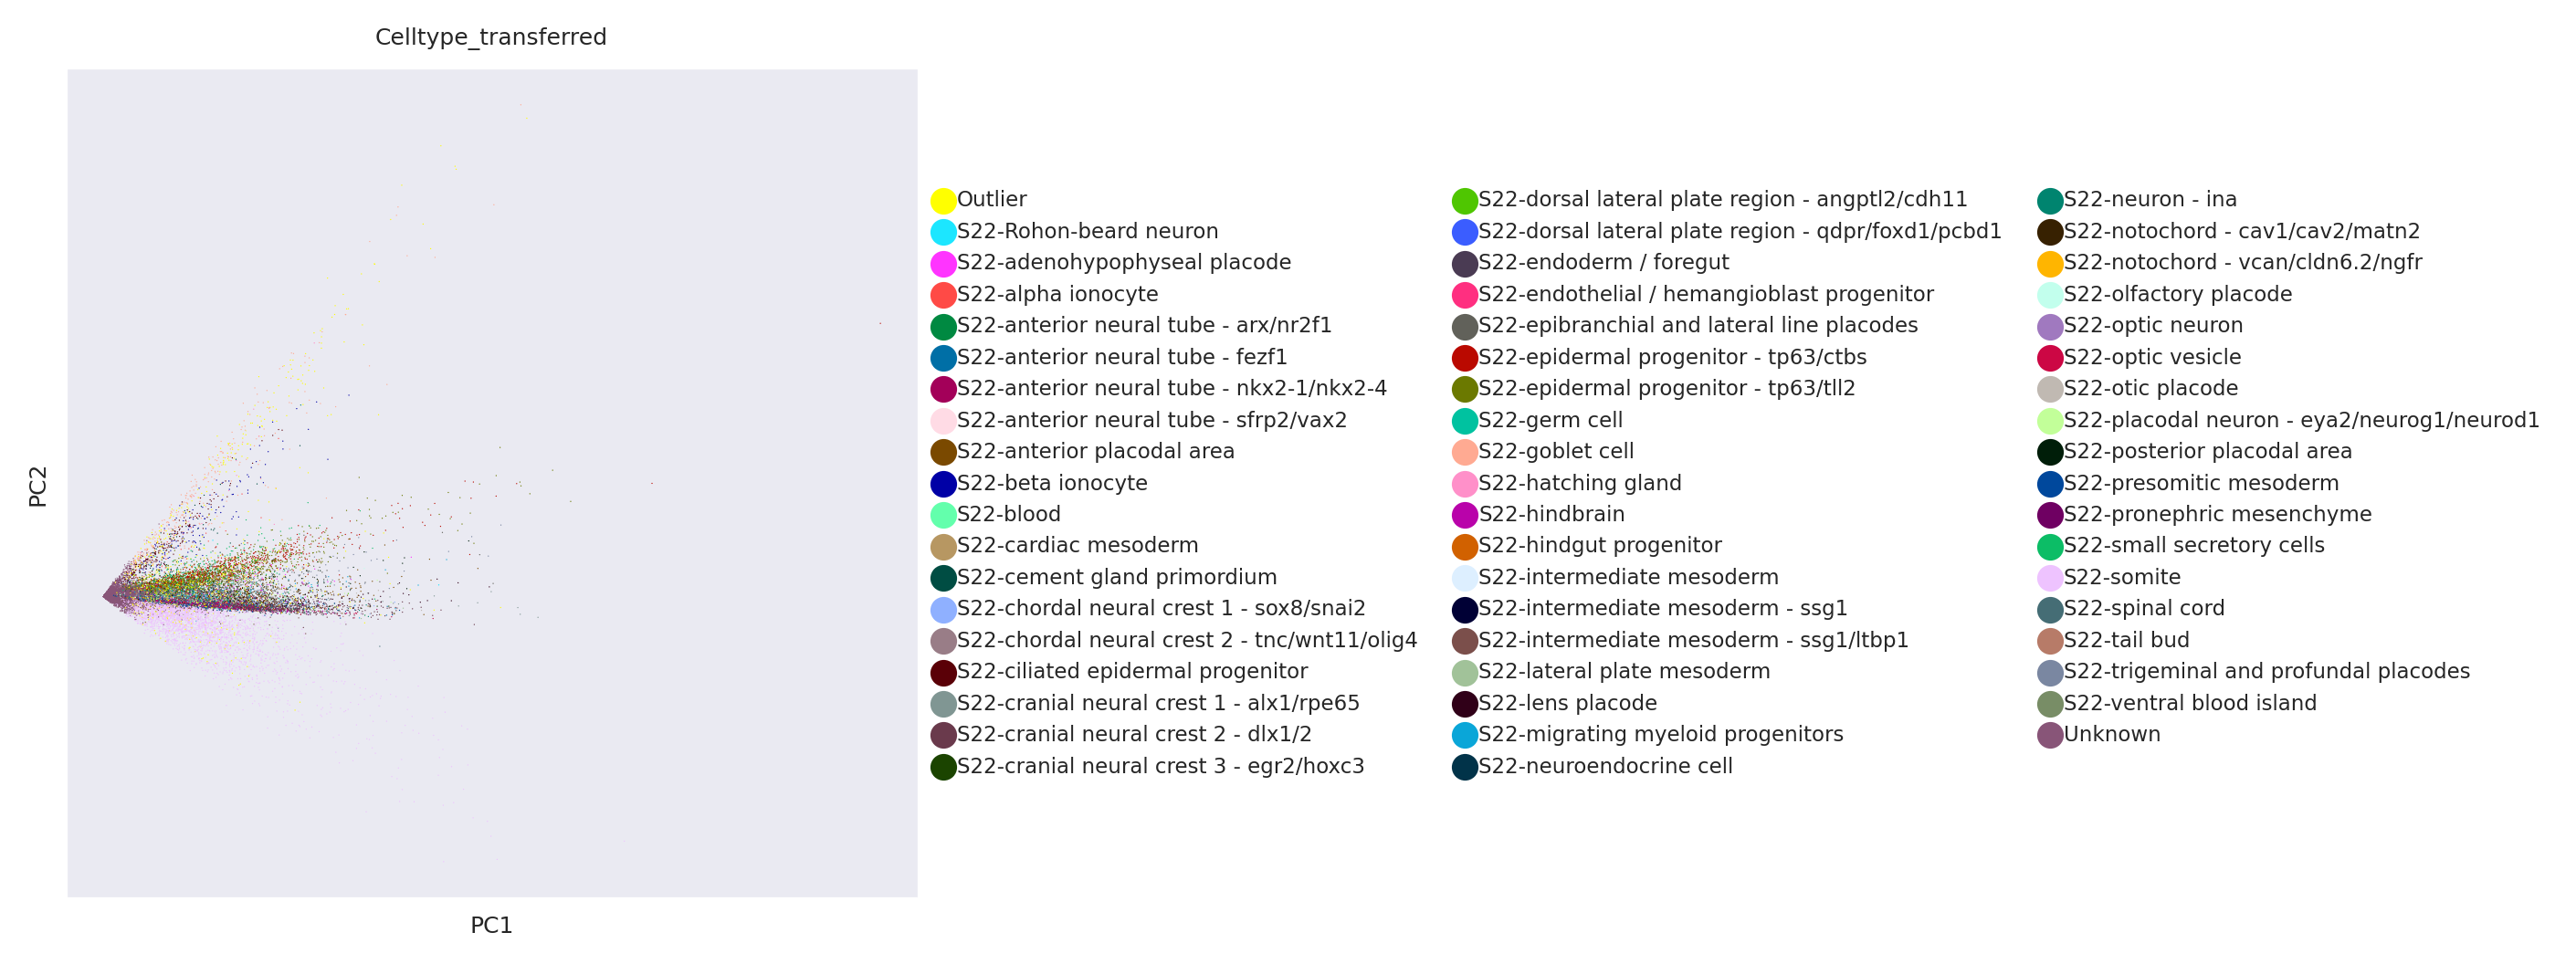

In [24]:
sc.pl.pca(adata, color="Celltype_transferred")

/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(c

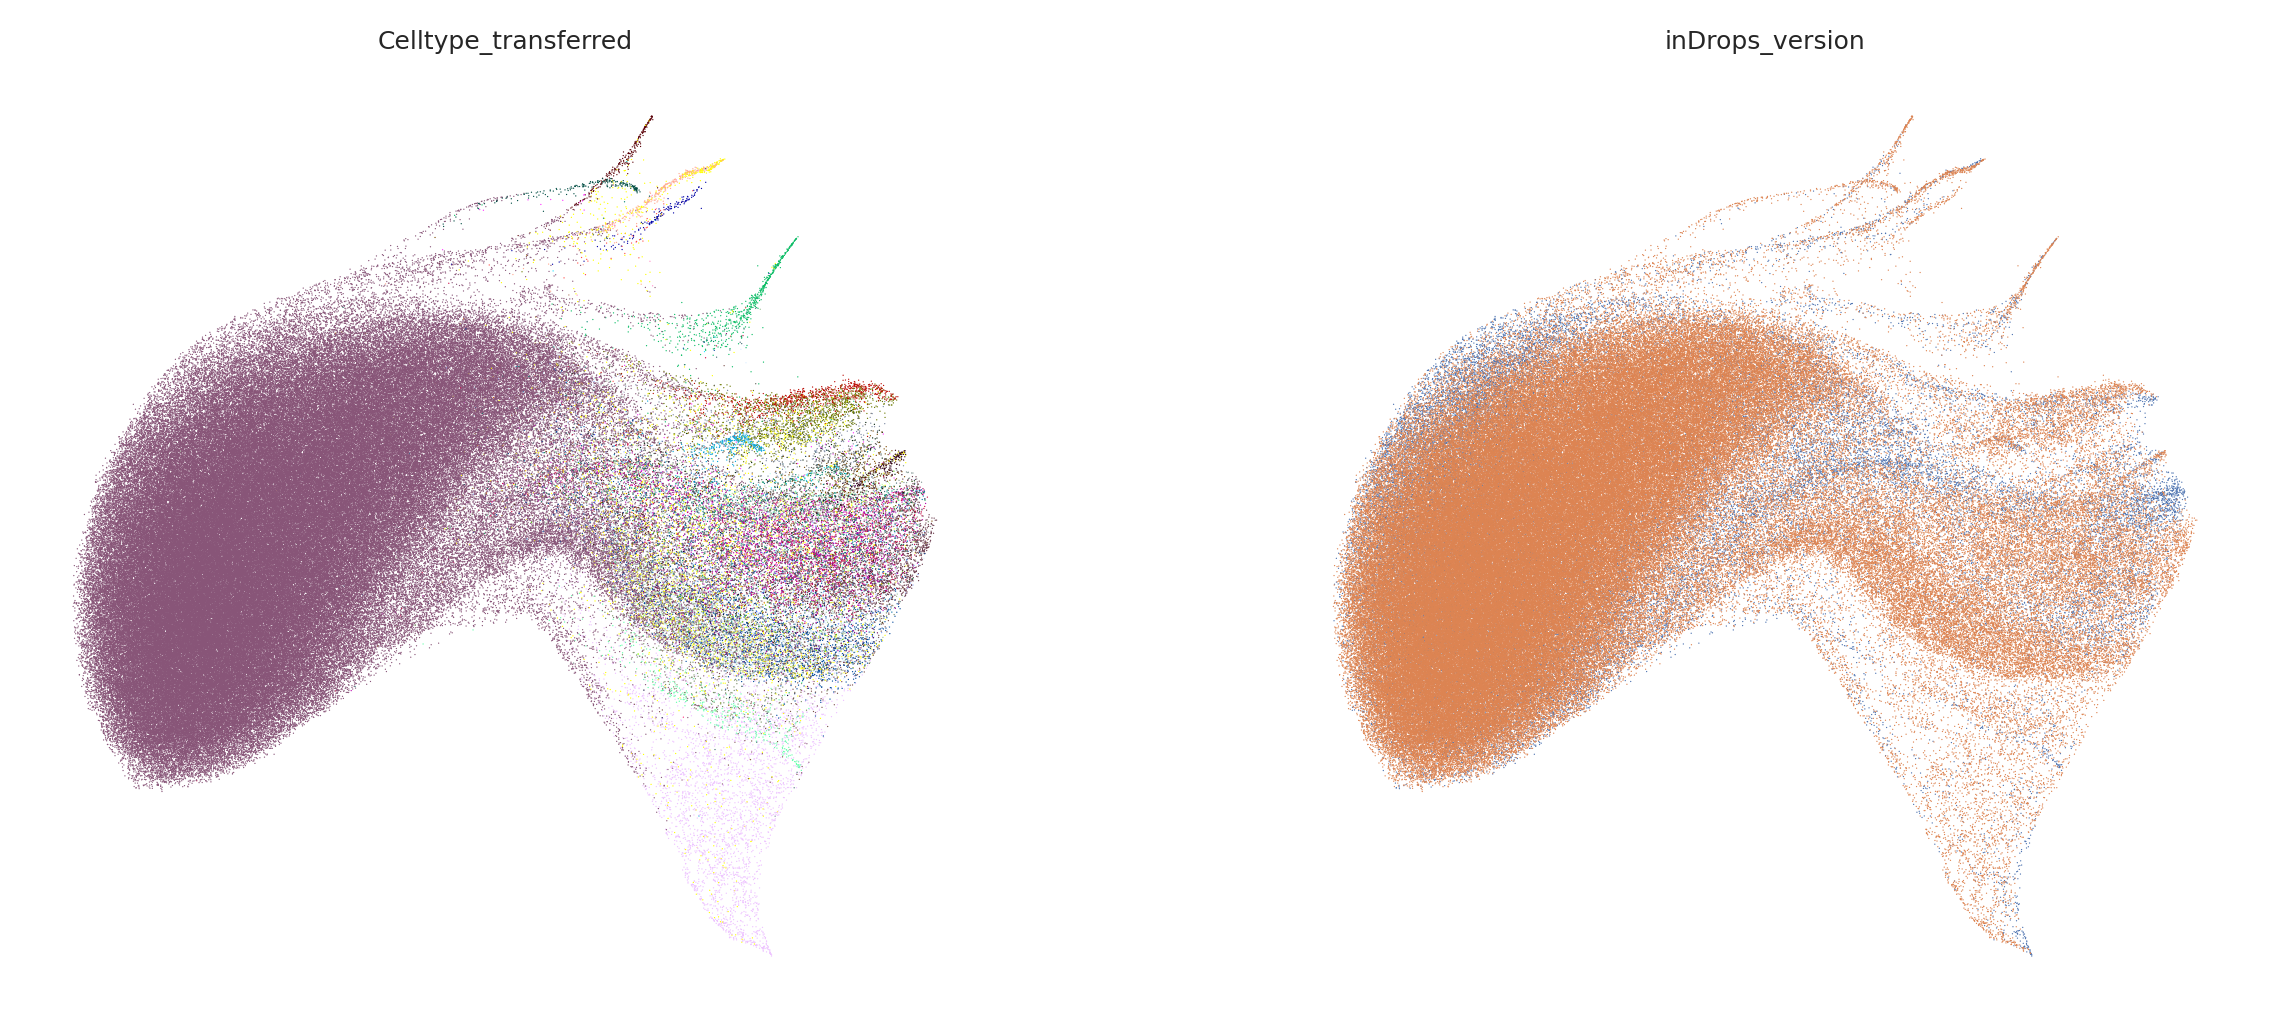

In [25]:
sc.pl.umap(adata, color=["Celltype_transferred", "inDrops_version"], frameon=False, legend_loc=False)

In [26]:
adata.obs["Celltype_known"] = "Known"
adata.obs.loc[adata.obs.Celltype_transferred == "Unknown", "Celltype_known"] = "Unknown"

/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ksp503/.conda/envs/xenopus/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


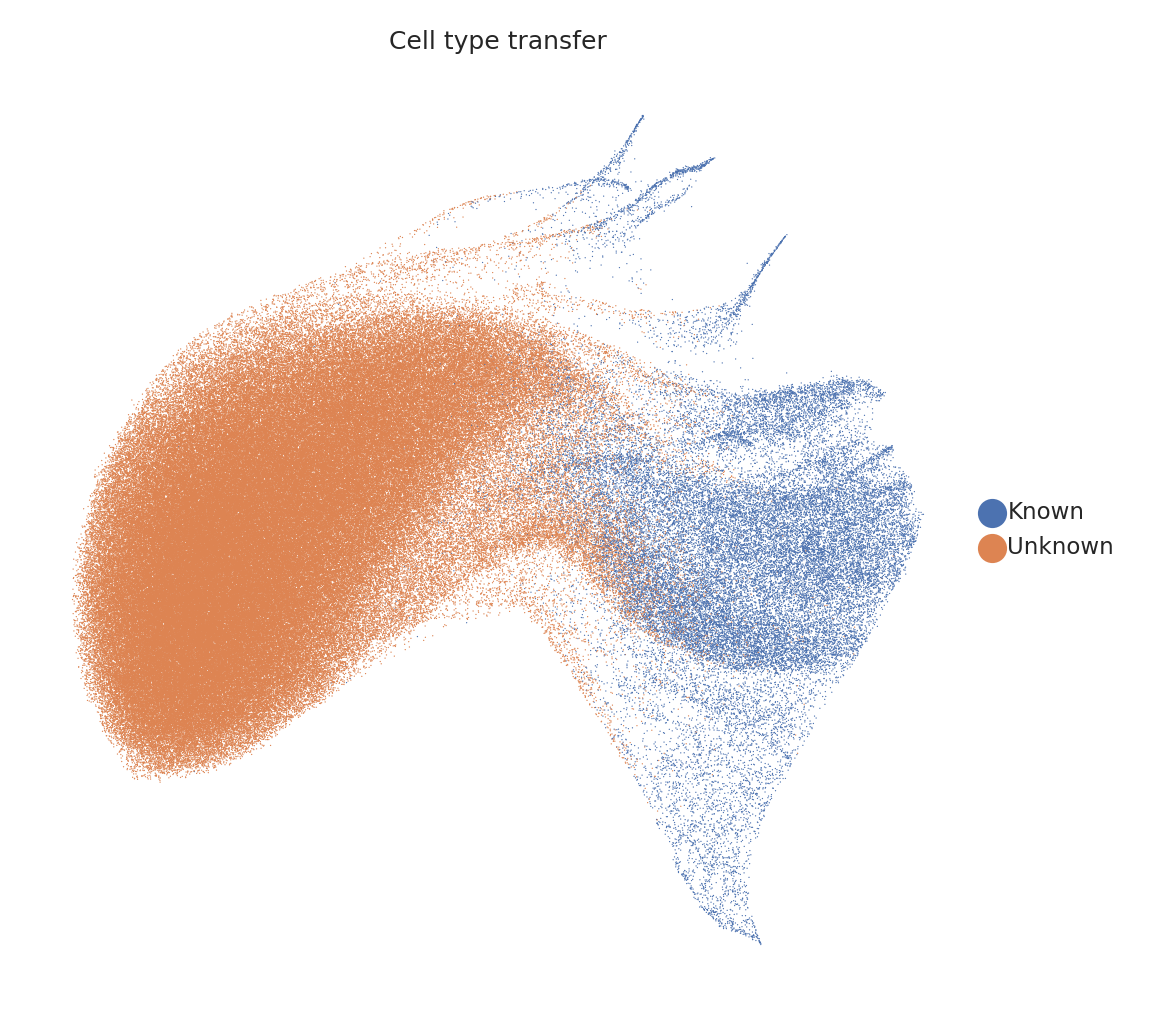

In [27]:
sc.pl.umap(adata, color=["Celltype_known"], frameon=False, title=["Cell type transfer"])

In [29]:
# noggin
# sc.pl.umap(adata, color="Xetrov107010415m")

In [28]:
adata.obs.Celltype_transferred.value_counts()

Celltype_transferred
Unknown                                               276556
Outlier                                                 3409
S22-somite                                              3408
S22-cranial neural crest 2 - dlx1/2                     3044
S22-intermediate mesoderm                               2675
S22-presomitic mesoderm                                 2332
S22-lateral plate mesoderm                              2140
S22-hindbrain                                           2079
S22-epidermal progenitor - tp63/tll2                    1494
S22-optic vesicle                                       1404
S22-spinal cord                                         1350
S22-intermediate mesoderm - ssg1/ltbp1                  1122
S22-epidermal progenitor - tp63/ctbs                     868
S22-epibranchial and lateral line placodes               836
S22-neuron - ina                                         804
S22-ventral blood island                                 791
S22

# Checkpoint

In [29]:
del adata.uns["pearson_residuals_normalization"]

KeyError: 'pearson_residuals_normalization'

In [29]:
adata.write(os.path.join(DATA_DIR, "adata", f"all.{NF_stage}.realigned.corrected.transferred.h5ad"))

In [29]:
adata

AnnData object with n_obs × n_vars = 39907 × 20289
    obs: 'lib', 'nUMI_per_cell', 'ngenes_per_cell', 'inDrops_version', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'cell_barcode', 'cell_barcode_v', 'Library_name', 'barcodes_unique', 'Celltype_transferred', 'Celltype_known'
    var: 'gene_name', 'human_id', 'human_name', 'human_desc', 'eval_forward', 'eval_backward', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'inDrops_version_colors', 'lib_colors', 'neighbors', 'pca', 'umap